In [131]:
import numpy as np
import matplotlib.pyplot as plt
import concurrent.futures

### Funciones de Percolaciones de Paredes 

In [126]:
def permutation():
    global order,N
    order = np.random.permutation(N)

# Setting the boundaries no PBC utilizando case, no hay vecino EMPTY
def vecino(s,j):
    global L,empty
    
    if j == 0: #izquierda
        if s%L ==0:
            return empty
        else:
            return s-1
    elif j==1: #derecha
        if s%L == L-1:
            return empty
        else:
            return s+1
    elif j==2: #abajo
        if s//L == 0:
            return empty
        else:
            return s-L
    elif j==3: #arriba
        if s//L == L-1:
            return empty
        else:
            return s+L
                
def boundaries():
    global N,nn
    for s in range(N):
        for j in range(4):
            nn[s,j] = vecino(s,j)

# Find operation de la raiz, versión no recursiva, no se cambian los ptr.
def findroot(r):
    global parent
    while parent[r] >= 0:
        r = parent[r]
    return r

In [127]:
#union de raíces (clusters), version no recursiva
def mergeroots(r1,r2):
    global spanclussize,parent,touchesLeft,touchesRight
    if r1 == r2:
        return r1
    elif -parent[r1] > -parent[r2]:
        parent[r1] += parent[r2]
        parent[r2] = r1
        #si alguno de los dos toca a la izquierda el compuesto tocará
        touchesLeft[r1] = touchesLeft[r1] or touchesLeft[r2] 
        #si alguno de los dos toca a la derecha  el compuesto tocará
        touchesRight[r1] = touchesRight[r1] or touchesRight[r2]
        if touchesLeft[r1] and touchesRight[r1]:
            #si el cluster toca a la izquierda y a la derecha existirá aglomerado expnadido
            spanclussize = -parent[r1]
        return r1 
    else:
        parent[r2] += parent[r1]
        parent[r1] = r2
        #si alguno de los dos toca a la izquierda el compuesto tocará
        touchesLeft[r2] = touchesLeft[r2] or touchesLeft[r1]
        #si alguno de los dos toca a la derecha  el compuesto tocará
        touchesRight[r2] = touchesRight[r2] or touchesRight[r1]
        if touchesLeft[r2] and touchesRight[r2]:
            #si el cluster toca a la izquierda y a la derecha existirá aglomerado expnadido
            spanclussize = -parent[r2]
        return r2        

In [128]:
def percolate():
    global spanclussize,order,parent,nn
    BIG = []
    PSpan = []
    big=0
    spanclussize = 0
    
    #for i in range(N): parent[i]=empty    

    for i in range(N):
        r1=s1=order[i]
        parent[s1] = -1
                
        for j in range(4):
            s2=nn[s1, j]
            if s2 != empty:
                if parent[s2] != empty:
                    r1 = mergeroots(r1,findroot(s2))
                    if -parent[r1]>big: big=-parent[r1]
        BIG.append(big)
        PSpan.append(spanclussize/(i+1.))

    return np.array(BIG), np.array(PSpan)

### a), b) y c)

In [134]:
global L, N, empty, parent, nn, order, spanclussize, touchesLeft, touchesRight
L = 128   # no. de celdas por lado
N = L**2   # no. de celdas
empty = -(N + 1)
muestras = 100 # no. de realizaciones

bigprom = np.zeros(N)  # promedio del tamaño de los arreglos 
Pspanprom = np.zeros(N) # prob de que el sistema percole promedio
Probprom = np.zeros(N)   # probabilidad de ocupación promedio
nn = np.zeros((N, 4), dtype=int)
boundaries() 

order = np.zeros(N, dtype=int) 
touchesLeft = np.arange(N) % L == 0
touchesRight = np.arange(N) % L == L - 1

for _ in range(muestras):
    parent = empty * np.ones(N, dtype=int)
    permutation()
    boundaries()
    BIG, PSpan = percolate()
    Prob = np.copy(PSpan)
    Prob[PSpan > 0] = 1
    bigprom += BIG
    Pspanprom += PSpan
    Probprom += Prob

bigprom /= muestras     # promedio del tamaño del cluster más grande
Pspanprom /= muestras  # prob de que una celda ocupada pertenezca al cluster que percola 
Probprom /= muestras

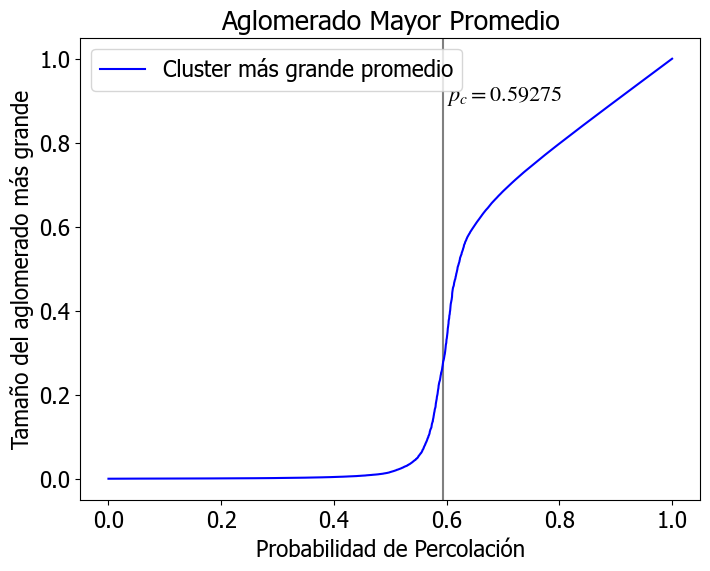

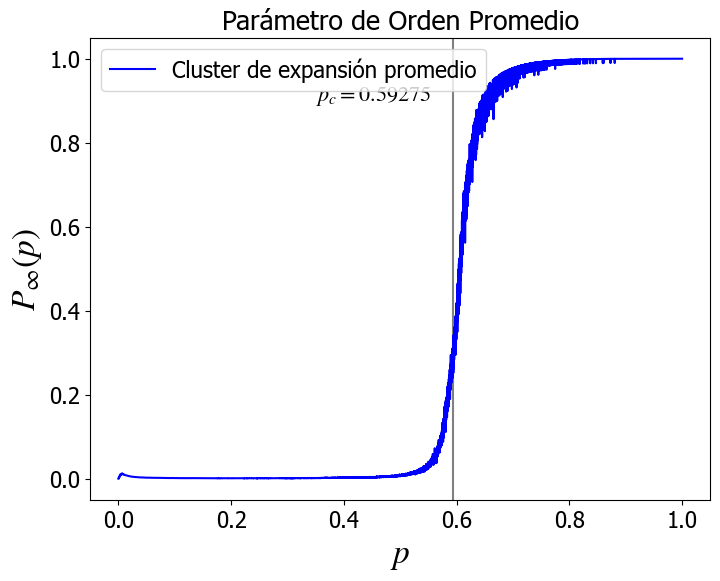

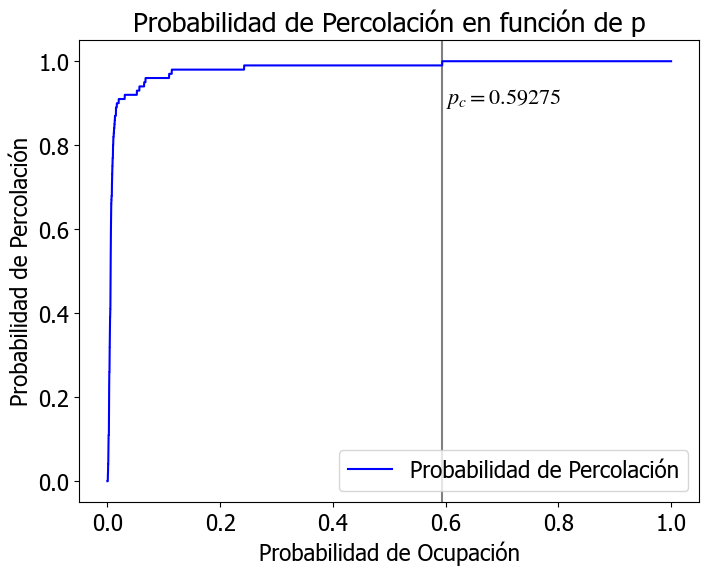

In [135]:
# Gráficas
plt.rcParams['font.size'] = '16'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Tahoma']
plt.rc('mathtext', fontset='stix')

# Gráfica del aglomerado más grande
plt.figure(figsize=(8, 6))
p = np.arange(1, N + 1) / N
promedio_BIG = bigprom / N
plt.plot(p, promedio_BIG, 'b-', label="Cluster más grande promedio")
plt.xlabel("Probabilidad de Percolación")
plt.ylabel("Tamaño del aglomerado más grande")
plt.title("Aglomerado Mayor Promedio")
plt.axvline(0.59275, color="gray", zorder=-1)
plt.text(0.6, 0.9 * promedio_BIG.max(), r'$p_c = 0.59275$')
plt.legend()
plt.show()

# Gráfica del parámetro de orden
plt.figure(figsize=(8, 6))
plt.plot(p, Pspanprom, 'b-', label="Cluster de expansión promedio")
plt.xlabel(r"$p$", fontsize=24)
plt.ylabel(r'$P_\infty(p)$', fontsize=24)
plt.title("Parámetro de Orden Promedio")
plt.axvline(0.59275, color="gray", zorder=-1)
plt.text(0.35, 0.9, r'$p_c = 0.59275$')
plt.legend()
plt.show()

# Gráfica de la probabilidad de percolación
plt.figure(figsize=(8, 6))
plt.plot(p, Probprom, 'b-', label="Probabilidad de Percolación")
plt.xlabel("Probabilidad de Ocupación")
plt.ylabel("Probabilidad de Percolación")
plt.title("Probabilidad de Percolación en función de p")
plt.axvline(0.59275, color="gray", zorder=-1)
plt.text(0.6, 0.9, r'$p_c = 0.59275$')
plt.legend()
plt.show()